# STIPS Basic Tutorial

If you prefer to work within a Jupyter notebook, this notebook will follow the same processes as the Basic Tutorial to create a STIPS observation. Like the Basic Tutorial, it assumes that you already have STIPS installed; see [Installing STIPS](https://stsci-stips.readthedocs.io/en/latest/installation.html) in the STIPS documentation if not.

## Importing STIPS and checking the STIPS environment

In order to use STIPS, you must have several sets of data files installed ([Installing STIPS](https://stsci-stips.readthedocs.io/en/latest/installation.html) contains instructions on doing this). In order to test your STIPS installation, STIPS includes an environment report utility that shows which version of STIPS you have installed, as well as the versions of the most important support packages that STIPS uses. When you run the cell below, you should get output something like this:

> STIPS Version x.y.z with Data Version x.y.z at /Some/Path/To/stips_data
>
> STIPS Grid Generated with x.y.z
>
> Pandeia Version a.b.c with Data Version a.b.c at /Some/Path/To/pandeia_refdata
>
> Webbpsf Version d.e.f with Data Version d.e.f at /Some/Path/To/WEBBPSF_PATH

In [ ]:
import stips

print(stips.__env__report__)

## Setting up some Basics

STIPS allows you to set up some basic elements of your observation and pass them when creating and running observations. The section below shows one way to set these up.

In [2]:
obs_prefix = 'notebook_example'
obs_ra = 150.0
obs_dec = -2.5

## Creating a Scene to Observe

STIPS contains functions to generate stellar populations as well as background galaxies. These functions are all present in the `SceneModule` class. In order to know what sort of populations to generate, the Scene Module requires input dictionaries to specify population parameters. In this example, we will create the following:

* A stellar population representing a globular cluster with
  * 100 stars
  * An age of 7.5 billion years
  * A metallicity of -2.0
  * A Salpeter IMF with alpha=-2.35
  * A binary fraction of 10%
  * A clustered distribution (higher-mass stars closer to the population centre)
  * An inverse power-law distribution
  * A radius of 100 parsecs
  * A distance of 10 kpc
  * No offset from the centre of the scene being created
* A collection of background galaxies with
  * 10 galaxies
  * Redshifts between 0 and 0.2
  * Radii between 0.01 and 2.0 arcsec
  * V-band surface brightness magnitudes between 28 and 24
  * Uniform spatial distribution (unclustered) over 200 arcsec
  * No offset from the center of the scene being created
  

##### Note: 
Background galaxies are available in STIPS, but are neither supported nor tested.
  

In [ ]:
from stips.scene_module import SceneModule

scm = SceneModule(out_prefix=obs_prefix, ra=obs_ra, dec=obs_dec)

stellar_parameters = {
                      'n_stars': 100,
                      'age_low': 7.5e12, 
                      'age_high': 7.5e12,
                      'z_low': -2.0, 
                      'z_high': -2.0,
                      'imf': 'salpeter', 
                      'alpha': -2.35,
                      'binary_fraction': 0.1,
                      'clustered': True,
                      'distribution': 'invpow',
                      'radius': 100.0, 
                      'radius_units': 'pc',
                      'distance_low': 10.0, 
                      'distance_high': 10.0,
                      'offset_ra': 0.0, 
                      'offset_dec': 0.0
                     }

stellar_cat_file = scm.CreatePopulation(stellar_parameters)
print("Stellar population saved to file {}".format(stellar_cat_file))

galaxy_parameters = {
                     'n_gals': 10,
                     'z_low': 0.0, 
                     'z_high': 0.2,
                     'rad_low': 0.01, 
                     'rad_high': 2.0,
                     'sb_v_low': 28.0, 
                     'sb_v_high': 24.0,
                     'distribution': 'uniform', 
                     'clustered': False,
                     'radius': 200.0, 
                     'radius_units': 'arcsec',
                     'offset_ra': 0.0, 
                     'offset_dec': 0.0
                    }

galaxy_cat_file = scm.CreateGalaxies(galaxy_parameters)
print("Galaxy population saved to file {}".format(galaxy_cat_file))

## Creating a STIPS observation

Once a scene has been created, it's possible to observe that scene as many times as you wish (and from as many places as you wish, although obviously any observation that doesn't include at least some of the scene will simply be an empty exposure). In this case, we create a single Roman WFI observation.

STIPS uses a bit of specialialized terminology to describe its observations. In particular:

* An *observation* is a set of exposures with a single instrument (e.g. Roman WFI), one or more filters (where each
  exposure in the observation will be repeated for every included filter), some number of the instrument's 
  detectors (for WFI between 1 and 18), where each exposure in the observation will be repeated, with the 
  appropriate inter-detector offset, for every included detector, a single chosen sky background value, and a  
  single exposure time (applied to each exposure in the observation), and one or more offsets.
* An *offset* is a single telescope pointing. For each offset specified in the observation, an exposure will be 
  created for each detector and each filter at the offset. STIPS may, optionally, create one or more mosaics at 
  each offset, with a single mosaic including all detectors with the same filter. In addition, STIPS can create a 
  single combined mosaic for each filter in the combined Observation.

In this case, we will create an observation with:

* Roman WFI F129
* 1 detector
* No distortion
* A sky background of 0.15 counts/s/pixel
* The ID 1
* An exposure time of 1000 seconds

We will use a single offset with:

* An ID of 1
* No centering (if an offset is centred then, for a multi-detector observation, each detector is centred on the   
  offset co-ordinates individually rather than the instrument as a whole being centred there)
* No change in RA, DEC, or PA from the centre of the observation

and the following residual settings:

* Flatfield residual: off
* Dark current residual: off
* Cosmic ray removal residual: off
* Poisson noise residual: on
* Readnoise residual: on


In [ ]:
from stips.observation_module import ObservationModule

offset = {
          'offset_id': 1,
          'offset_centre': False,
          'offset_ra': 0.0,
          'offset_dec': 0.0,
          'offset_pa': 0.0
         }

residuals = {
             'residual_flat': False,
             'residual_dark': False,
             'residual_cosmic': False,
             'residual_poisson': True,
             'residual_readnoise': True,
            }

observation_parameters = {
                          'instrument': 'WFI',
                          'filters': ['F129'],
                          'detectors': 1,
                          'distortion': False,
                          'background': 0.15,
                          'observations_id': 1,
                          'exptime': 1000,
                          'offsets': [offset]
                         }

obm = ObservationModule(observation_parameters, out_prefix=obs_prefix, ra=obs_ra, dec=obs_dec, residuals=residuals)

Finally, we call nextObservation() -– this function is used to move between different combinations of offset and filter.  It must be called once in order to initialize the observation module to the first observatiom before adding catalogues.

In [ ]:
obm.nextObservation()

## Observing the Scene

In order to observe the scene, we must add the scene catalogues created above to it, add in error residuals, and finalize the observation. In so doing, we create output catalogues which are taken from the input catalogues, but only contain the sources visible to the detectors, and convert source brightnesses into units of counts/s for the detectors.

In [ ]:
output_stellar_catalogues = obm.addCatalogue(stellar_cat_file)
output_galaxy_catalogues = obm.addCatalogue(galaxy_cat_file)

print("Output Catalogues are {} and {}.".format(output_stellar_catalogues, output_galaxy_catalogues))

psf_file = obm.addError()

print("PSF File is {}".format(psf_file))

fits_file, mosaic_file, params = obm.finalize(mosaic=False)

print("Output FITS file is {}".format(fits_file))
print("Output Mosaic File is {}".format(mosaic_file))
print("Observation Parameters are {}".format(params))

## Show the Result

We use pyplot to plot the resulting simulated image.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
from matplotlib import style
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
import matplotlib.pyplot as plt
from astropy.io import fits

with fits.open(fits_file) as result_file:
    result_data = result_file[1].data

fig1 = plt.figure()
im = plt.matshow(result_data)
plt.savefig('notebook_example_basic_scene.jpeg')

As well as a detail from the detector center.

<Figure size 432x288 with 0 Axes>

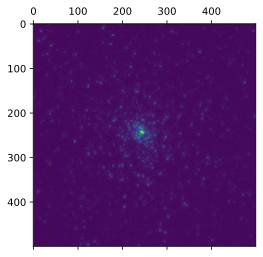

In [9]:
fig2 = plt.figure()
im2 = plt.matshow(result_data[1800:2300, 1800:2300])
plt.savefig('notebook_example_basic_scene.jpeg')